In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from keras.datasets import mnist
import math
from sklearn import preprocessing
from sklearn import metrics 
import seaborn as sns 
import sys

2021-11-10 10:29:15.570812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/peshal/opencv/build/lib
2021-11-10 10:29:15.570837: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
np.random.seed(42)

In [4]:
(X_train, Y_train),(X_test,Y_test)=mnist.load_data()

In [5]:
# Normalize input for training purpose
X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
X_train=X_train/255-0.5
X_test=X_test/255-0.5

In [6]:
# reshaping input from (28,28) to (784,)
X_train_reshaped=X_train.reshape((len(X_train),-1))
X_test_reshaped=X_test.reshape((len(X_test),-1))

In [21]:
class simplenetwork:
    def __init__(self,epochs,learning_rate,batches,layers,activation="sigmoid",loss_function="MSE",weights=None):
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.batches=batches
        self.weights=weights
        self.layers=layers
        self.loss_function=loss_function
        self.activation=activation
        # select an activation function which is used inside the nodes
        if activation.lower()=="sigmoid":
            self.activation_func= self.sigmoid_
            self. activation_func_for_output=self.sigmoid_
            self.activation_func_derivative=self.derivative_sigmoid
        elif activation.lower()=="tanh":
            self.activation_func= self.tanh_
            self. activation_func_for_output=self.tanh_
            self.activation_func_derivative=self.derivative_tanh
        elif activation.lower()=="relu":
            self.activation_func= self.relu_
            self. activation_func_for_output=self.relu_
            self.activation_func_derivative=self.derivative_relu
        else:
            print("give proper activation function")
        # select an loss function
        if loss_function.lower()=="mse":
            self.loss_calc=self.MSE
            self.loss_gradient=self.MSE_gradient
        elif loss_function.lower()=="cross_entropy":
            self.loss_calc=self.cross_entropy
            self.loss_gradient=self.cross_entropy_gradient
        elif loss_function.lower()=="categorical_cross_entropy":
            self.loss_calc=self.categorical_cross_entropy
            self.loss_gradient=self.categorical_cross_entropy_gradient
            self.activation_func_for_output=self.softmax
        else:
            print("give proper loss function")
        
        
    def get_weights(self):
        return self.weights
    
    def sigmoid_(self,hypothesis_value):
        hypothesis_value_copy=np.copy(hypothesis_value)
        return (1/(1+np.exp(-hypothesis_value_copy)))

    def tanh_(self,hypothesis_value):
        hypothesis_value_copy=np.copy(hypothesis_value)
        return (np.exp(hypothesis_value_copy)-np.exp(-hypothesis_value_copy))/(np.exp(hypothesis_value_copy)+np.exp(-hypothesis_value_copy))

    def relu_(self,hypothesis_value):
        hypothesis_value_copy=np.copy(hypothesis_value)
        hypothesis_value_copy=np.where(hypothesis_value_copy>=0,hypothesis_value_copy,0)
        return hypothesis_value_copy

    def softmax(self,hypothesis_value):
        hypothesis_value_copy=np.copy(hypothesis_value)
        exponential_of_hypothesis=np.exp(hypothesis_value_copy)
        sum_along_row=np.sum(exponential_of_hypothesis,axis=1)
        return np.divide(exponential_of_hypothesis,sum_along_row[:,None])
        
    def derivative_sigmoid(self, x_value):
        x_value_copy=np.copy(x_value)
        return x_value_copy*(1-x_value_copy)

    def derivative_tanh(self,x_value):
        x_value_copy=np.copy(x_value)
        return (1-x_value_copy**2)

    def derivative_relu(self,x_value):
        x_value_copy=np.copy(x_value)
        x_value_copy=np.where(x_value_copy>0,1,0)
        return x_value_copy

    def MSE(self,Yactual,Ypredict):
        Y_actual=np.copy(Yactual)
        Y_predict=np.copy(Ypredict[:,1:])
        loss_func=(Y_actual-Y_predict)**2
        cost_func=np.sum(loss_func,axis=0)/len(loss_func)
        return np.sum(cost_func)/len(cost_func)

    def cross_entropy(self,Yactual,Ypredict):
        Y_actual=np.copy(Yactual)
        Y_predict=np.copy(Ypredict)
        logistic_func=np.ones(Y_actual.shape)
        for i in range(len(Y_predict)):
            for j in range(1,len(Y_predict[0])):
                value1=Y_predict[i][j]
                value2=1-Y_predict[i][j]
                if value1<=0 :
                    value1=0.00000000000001
                elif value2<=0 :
                    value2=0.00000000000001
                logistic_func[i][j-1]=(-Y_actual[i][j-1]*math.log(value1)-(1-Y_actual[i][j-1])*math.log(value2))
        cost_func=np.sum(logistic_func,axis=0)/len(logistic_func)
        return np.sum(cost_func)/len(cost_func)

    def categorical_cross_entropy(self,Yactual,Ypredict):
        Y_actual=np.argmax(Yactual,axis=1)
        Y_predict=np.copy(Ypredict[:,1:])
        cross_entropy=0
        for i in range(len(Y_predict)):
            j=Y_actual[i]
            p=Y_predict[i][j]
            if p<=0:
                p=0.00000000000001
            cross_entropy-=math.log(p)
        return cross_entropy/len(Y_predict)

    def categorical_cross_entropy_derivative(self,Yactual,Ypredict):
        Y_actual=np.copy(Yactual)
        Y_predict=np.copy(Ypredict)
        for i in range(len(Y_predict)):
            j=Y_actual[i]
            Y_predict[i][j]=(Y_predict[i][j]-1)
        return Y_predict

    def categorical_cross_entropy_gradient(self,Yactual,Ypredict,nodes_,weights_,number_of_layers,derivation_func):
        Y_actual=np.argmax(Yactual,axis=1)
        Y_predict=np.copy(Ypredict)
        actual_diff=self.categorical_cross_entropy_derivative(Y_actual,Y_predict)
        cost_func_derivative=[]
        for i in range((number_of_layers-1)):
            node_index=-(2+i)
            cost_func_derivative.append(np.dot(np.transpose(actual_diff),nodes_[node_index])/len(actual_diff))
            actual_diff=np.dot(actual_diff,(weights_[node_index+1])[:,1:])
            actual_diff=actual_diff*derivation_func((nodes_[node_index])[:,1:])
        return cost_func_derivative

    def cross_entropy_gradient(self,Yactual,Ypredict,nodes_,weights_,number_of_layers,derivation_func):
        Y_actual=np.copy(Yactual)
        Y_predict=np.copy(Ypredict)
        Y_actual=np.where(Y_actual==0,0.00000000001,Y_actual)
        Y_actual=np.where(Y_actual==1,0.99999999999,Y_actual)
        Y_predict=np.where(Y_predict==0,0.00000000001,Y_predict)
        Y_predict=np.where(Y_predict==1,0.99999999999,Y_predict)
        actual_diff=-((Y_actual-Y_predict)/(Y_predict*(1-Y_predict)))*derivation_func(Y_predict)
        cost_func_derivative=[]
        for i in range((number_of_layers-1)):
            node_index=-(2+i)
            cost_func_derivative.append(np.dot(np.transpose(actual_diff),nodes_[node_index])/len(actual_diff))
            actual_diff=np.dot(actual_diff,(weights_[node_index+1])[:,1:])
            actual_diff=actual_diff*derivation_func((nodes_[node_index])[:,1:])
        return cost_func_derivative

    def MSE_gradient(self,Yactual,Ypredict,nodes_,weights_,number_of_layers,derivation_func):
        Y_actual=np.copy(Yactual)
        Y_predict=np.copy(Ypredict)
        actual_diff=(Y_predict-Y_actual)*derivation_func(Y_predict)
        cost_func_derivative=[]
        for i in range((number_of_layers-1)):
            node_index=-(2+i)
            cost_func_derivative.append(np.dot(np.transpose(actual_diff),nodes_[node_index])/len(actual_diff))
            actual_diff=np.dot(actual_diff,(weights_[node_index+1])[:,1:])
            actual_diff=actual_diff*derivation_func((nodes_[node_index])[:,1:])
        return cost_func_derivative

    def fit(self, X_train,Y_train):
        # preprocessing the output label so that classification step can be used 
        lb = preprocessing.LabelBinarizer()
        lb.fit(Y_train)
        Y_train=lb.transform(Y_train) 
        X_train_new=np.ones((len(X_train),len(X_train[0])+1))
        Number_features=len(X_train_new[0])
        X_train_new[:,1:]=X_train
        layers=[Number_features]
        layers.extend(self.layers)
        Number_of_output_labels=len(Y_train[0])
        layers.append(Number_of_output_labels)
        layer_=np.array(layers)
        parameters=np.copy(layer_)
        parameters[1:]+=1
        number_of_layers=len(layer_)
        weights_=[]
        number_of_trainingset=int(len(X_train)/self.batches)
        # weights are initialize in such a way that their mean equal zero and variation will equal 2/ (input parameters+output parameters)
        for i in range(1,number_of_layers):
            weights_.append(np.random.normal(loc=0.0, scale = np.sqrt(2/(parameters[i]-1+parameters[i-1])), size = (parameters[i]-1,parameters[i-1])))

        for number_of_epochs in range(self.epochs):
            lossfunc=np.ones(shape=(Y_train.shape))
            mean_error=0
            # based on batch sizes images are divided into batches or groups and are trained accrodingly
            for batch in range(self.batches):
                start=0
                end=0;
                if (batch+1)*number_of_trainingset < len(X_train_new):
                    start=int(batch*number_of_trainingset)
                    end=int(start+number_of_trainingset)
                else:
                    start=int(batch*number_of_trainingset)
                    end=int(len(X_train_new))
                X_train_batch=X_train_new[start:end,:]
                Y_train_batch=Y_train[start:end,:]
                # each hidden layer has minimum one number of node
                # number of nodes is assigned based on humber provided by user
                nodes_=[X_train_batch]
                for i in range(1,number_of_layers):
                    nodes_.append(np.ones(shape=(len(X_train_batch),parameters[i])))
                # output for each node after passing weighted input sum through activation function 
                for k in range(1,(number_of_layers)): 
                    hypothesis=nodes_[k]
                    weights_transpose=np.transpose(weights_[k-1])
                    input_for_node=nodes_[k-1]
                    hypothesis_value=np.dot(input_for_node,weights_transpose)
                    # for output of final layers is compared with actual output label to get loss 
                    if k+1==number_of_layers:
                        hypothesis[:,1:]=self.activation_func_for_output(hypothesis_value)
                        mean_error=self.loss_calc(Y_train_batch,hypothesis)
                    else:
                        hypothesis[:,1:]=self.activation_func(hypothesis_value)
                Y_predict=np.copy(nodes_[-1])[:,1:]
                # Implementation of gradient descent
                cost_func_derivative=self.loss_gradient(Y_train_batch,Y_predict,nodes_,weights_,number_of_layers,self.activation_func_derivative)
                for i in range(len(cost_func_derivative)):
                    weights_[i]=weights_[i]-self.learning_rate*cost_func_derivative[-(i+1)]

                # calculating accuracy after calculating output
                Y_predict=np.argmax(Y_predict,axis=1)
                Y_train_batch_one_dimesional=np.argmax(Y_train_batch,axis=1)
                unique_value,counts=np.unique(Y_predict==Y_train_batch_one_dimesional,return_counts=True)
            print("error: "+mean_error.__str__()+"  accuracy : "+( counts[1]/np.sum(counts)*100).__str__()+"%")
        self.weights=weights_

    def test(self,X_test,Y_test):
        lb = preprocessing.LabelBinarizer()
        lb.fit(Y_test)
        Y_test=lb.transform(Y_test)
        X_test_new=np.ones((len(X_test),len(X_test[0])+1))
        Number_features=len(X_test_new[0])
        X_test_new[:,1:]=X_test
        layers=[Number_features]
        layers.extend(self.layers)
        Number_of_output_labels=len(Y_test[0])
        layers.append(Number_of_output_labels)
        layer_=np.array(layers)
        parameters=np.copy(layer_)
        parameters[1:]+=1
        number_of_layers=len(layer_)
        accuracy=0
        mean_error=0
        lossfunc=np.zeros(Y_test.shape)
        nodes_=[X_test_new]  
        for i in range(1,number_of_layers):
            nodes_.append(np.ones(shape=(len(X_test_new),parameters[i])))
        for k in range(1,(number_of_layers)): 
            hypothesis=nodes_[k]
            weights_transpose=np.transpose(self.weights[k-1])
            input_for_node=nodes_[k-1]
            hypothesis_value=np.dot(input_for_node,weights_transpose)
            if k+1==number_of_layers:
                hypothesis[:,1:]=self.activation_func_for_output(hypothesis_value)
                mean_error=self.loss_calc(Y_test,hypothesis)
            else:
                hypothesis[:,1:]=self.activation_func(hypothesis_value)
            nodes_[k]=hypothesis
        Y_predict=np.copy(nodes_[-1])[:,1:]
        Y_predict=np.where(Y_predict>=0.5,1,0)
        Y_predict=np.argmax(Y_predict,axis=1)
        Y_test=np.argmax(Y_test,axis=1)
        unique_value,counts=np.unique(Y_predict==Y_test,return_counts=True)
        cf_matrix=metrics.confusion_matrix(Y_test,Y_predict, labels=[0,1,2,3,4,5,6,7,8,9])
        print(metrics.classification_report(Y_test,Y_predict, labels=[0,1,2,3,4,5,6,7,8,9],zero_division=0))
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.heatmap(cf_matrix, annot=True)
        print("error: "+mean_error.__str__()+" accuracy : "+ (counts[1]/np.sum(counts)*100).__str__()+"%")

            

In [23]:
model=simplenetwork(100,1,6,[15])
model.fit(X_train_reshaped,Y_train)

error: 0.09454746685000014  accuracy : 19.509999999999998%
error: 0.089386737362215  accuracy : 33.77%
error: 0.08842803525505966  accuracy : 35.6%
error: 0.08777813142654745  accuracy : 36.230000000000004%
error: 0.0870774226058319  accuracy : 37.72%
error: 0.08627968609620848  accuracy : 39.53%
error: 0.08544593099360577  accuracy : 41.980000000000004%
error: 0.0845800712371666  accuracy : 44.6%
error: 0.08367576071089938  accuracy : 46.550000000000004%
error: 0.08274548094987019  accuracy : 48.13%
error: 0.0818059194072791  accuracy : 49.66%
error: 0.08086382377487585  accuracy : 51.27%
error: 0.07991450782768823  accuracy : 52.78%
error: 0.07894541513690498  accuracy : 54.279999999999994%
error: 0.07793686043081269  accuracy : 55.7%
error: 0.07686976895361208  accuracy : 57.02%
error: 0.07575951806855909  accuracy : 57.92%
error: 0.07463974779401525  accuracy : 58.58%
error: 0.0735138533893537  accuracy : 59.11%
error: 0.07237846152846181  accuracy : 59.67%
error: 0.071233267113988

              precision    recall  f1-score   support

           0       0.29      1.00      0.45       980
           1       0.98      0.92      0.95      1135
           2       0.95      0.75      0.84      1032
           3       0.95      0.72      0.82      1010
           4       0.94      0.73      0.83       982
           5       0.98      0.31      0.47       892
           6       0.97      0.87      0.92       958
           7       0.94      0.81      0.87      1028
           8       0.96      0.60      0.74       974
           9       0.97      0.59      0.73      1009

    accuracy                           0.74     10000
   macro avg       0.89      0.73      0.76     10000
weighted avg       0.89      0.74      0.77     10000

error: 0.029405251867043836 accuracy : 73.63%


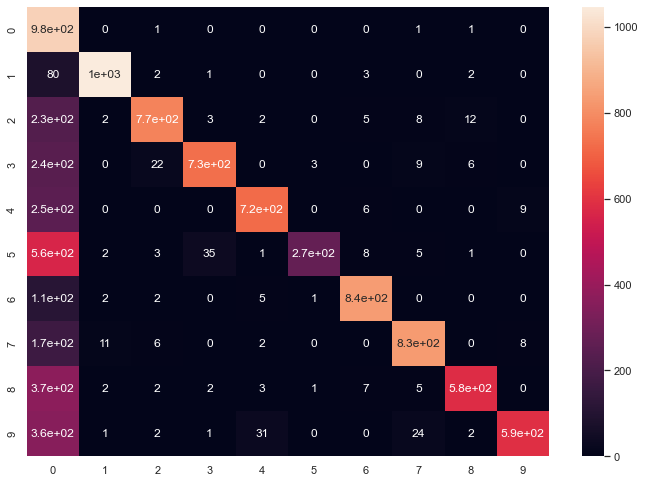

In [24]:
model.test(X_test=X_test_reshaped,Y_test=Y_test)

In [87]:
weights=model.get_weights()